In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.5 MB/s eta 0:00:00a 0:00:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 KB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 13.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 11.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 KB 26.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp39-cp39-linux_x86_64.whl size=298921 sha256=d6109f12d1ae29716122406cdcf1cf647041bab4998649134777637e63947e76
  Stored in directory: /home/jovyan/

In [9]:
import yfinance as yf

import functools

# Fetch historical data
@functools.lru_cache()
def fetch_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    return data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Average return for start years 2000-2010:
100% SPY                 203.539550
1% Cash, Rebalance 1%    202.673808
1% Cash, Rebalance 2%    202.504154
1% Cash, Rebalance 3%    202.504154
1% Cash, Rebalance 5%    202.504154
                            ...    
10% SHY, Rebalance 5%    197.138760
20% SHY, Rebalance 1%    186.220126
20% SHY, Rebalance 2%    186.205718
20% SHY, Rebalance 3%    186.224759
20% SHY, Rebalance 5%    188.674740
Length: 81, dtype: float64

Average return for start years 2011-2013:
100% SPY                 375.165463
1% Cash, Rebalance 1%    372.413809
1% Cash, Rebalance 2%    372.413809
1% Cash, Rebalance 3%    372.413809
1% Cash, Rebalance 5%    372.413809
                            ...    
10% SHY, Rebalance 5%    341.749597
20% SHY, Rebalance 1%    299.459696
20% SHY, Rebalance 2%    299.360155
20% SHY, Rebalance 3%    301.538379
20% SHY, Rebalance 5%    305.669441
Length: 81, dtype: float64


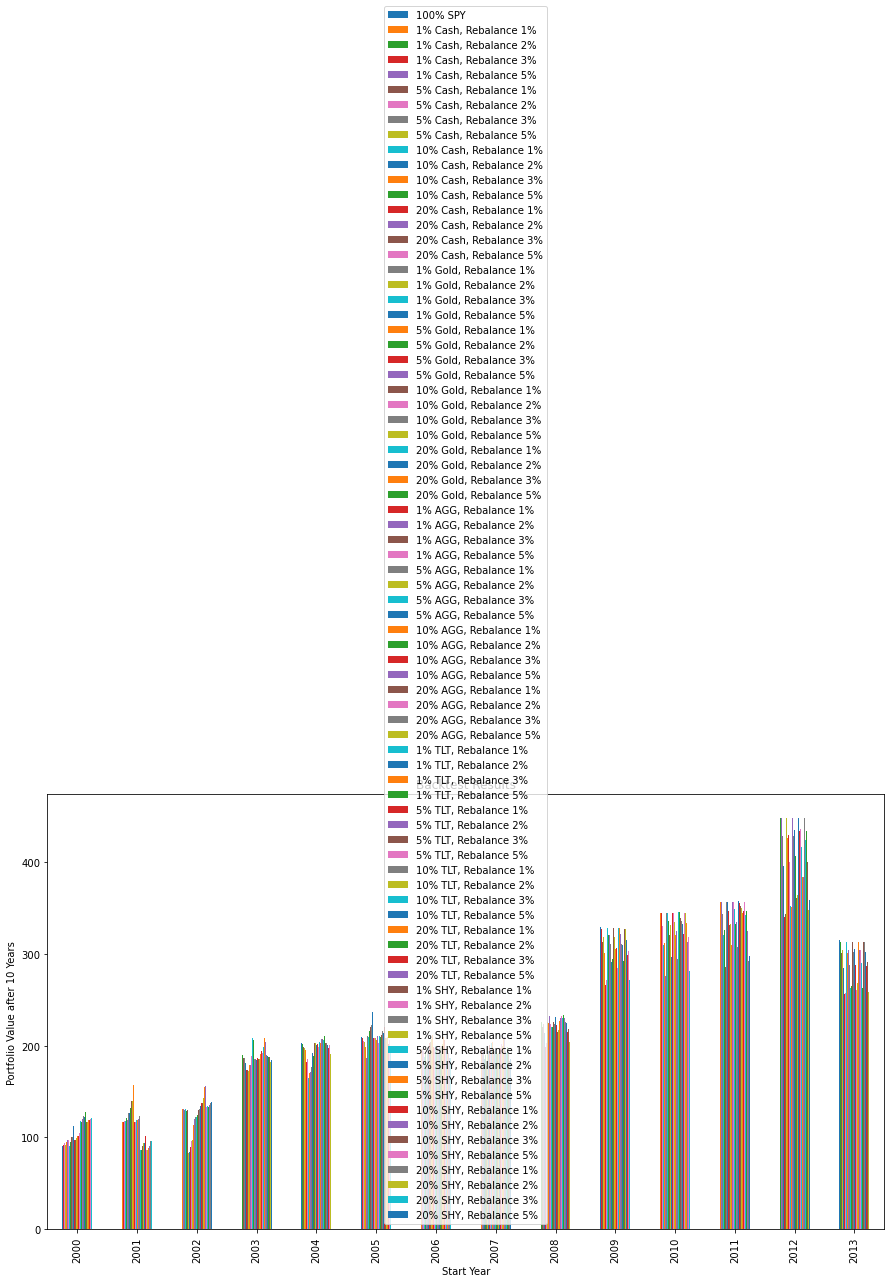

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Strategy 1: 100% SPY
def strategy_100_spy(prices, *args, **kwargs):
    portfolio_value = 100
    shares = portfolio_value / prices[0]
    portfolio_values = prices * shares
    return portfolio_values

# Strategy: SPY and alternative asset (cash, gold, bonds) with rebalancing
def strategy_spy_alt(prices, alt_prices, alt_allocation, rebalance_threshold):
    portfolio_value = 100
    spy_shares = (portfolio_value * (1 - alt_allocation)) / prices[0]
    alt_shares = (portfolio_value * alt_allocation) / alt_prices[0]
    portfolio_values = []

    for price, alt_price in zip(prices, alt_prices):
        portfolio_value = (spy_shares * price) + (alt_shares * alt_price)
        spy_allocation = (spy_shares * price) / portfolio_value
        alt_allocation_current = (alt_shares * alt_price) / portfolio_value

        if abs(spy_allocation - (1 - alt_allocation)) > rebalance_threshold:
            spy_shares = (portfolio_value * (1 - alt_allocation)) / price
            alt_shares = (portfolio_value * alt_allocation) / alt_price

        portfolio_values.append(portfolio_value)
    
    return portfolio_values

# Run backtests
def backtest_strategy(strategy, start_years, period_years, alt_ticker=None, **strategy_args):
    results = {}
    for start_year in start_years:
        start_date = f"{start_year}-01-01"
        end_date = f"{start_year + period_years}-01-01"
        prices = fetch_data('SPY', start=start_date, end=end_date)
        if alt_ticker:
            alt_prices = fetch_data(alt_ticker, start=start_date, end=end_date)
        else:
            alt_prices = prices * 0 + 1  # Dummy prices for 100% SPY strategy
        if not prices.empty and not alt_prices.empty:
            portfolio_values = strategy(prices, alt_prices, **strategy_args)
            results[start_year] = portfolio_values[-1]
    return results

# Parameters
start_years = range(2000, 2014)
period_years = 10
cash_allocations = [0.01, 0.05, 0.10, 0.20]
rebalance_thresholds = [0.01, 0.02, 0.03, 0.05]
bond_tickers = ['AGG', 'TLT', 'SHY']  # Total bond market, long-term, short-term

# Backtest the strategies
results = {}
results['100% SPY'] = backtest_strategy(strategy_100_spy, start_years, period_years)

# SPY and Cash
for cash_allocation in cash_allocations:
    for rebalance_threshold in rebalance_thresholds:
        strategy_name = f"{int(cash_allocation * 100)}% Cash, Rebalance {int(rebalance_threshold * 100)}%"
        results[strategy_name] = backtest_strategy(strategy_spy_alt, start_years, period_years, alt_allocation=cash_allocation, rebalance_threshold=rebalance_threshold)

# SPY and Gold
for gold_allocation in cash_allocations:
    for rebalance_threshold in rebalance_thresholds:
        strategy_name = f"{int(gold_allocation * 100)}% Gold, Rebalance {int(rebalance_threshold * 100)}%"
        results[strategy_name] = backtest_strategy(strategy_spy_alt, start_years, period_years, alt_ticker='GLD', alt_allocation=gold_allocation, rebalance_threshold=rebalance_threshold)

# SPY and Bonds
for bond_ticker in bond_tickers:
    for bond_allocation in cash_allocations:
        for rebalance_threshold in rebalance_thresholds:
            strategy_name = f"{int(bond_allocation * 100)}% {bond_ticker}, Rebalance {int(rebalance_threshold * 100)}%"
            results[strategy_name] = backtest_strategy(strategy_spy_alt, start_years, period_years, alt_ticker=bond_ticker, alt_allocation=bond_allocation, rebalance_threshold=rebalance_threshold)

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_results['Year'] = start_years
df_results.set_index('Year', inplace=True)

# Calculate average returns
def calculate_average_return(df, start_year_range):
    filtered_df = df.loc[start_year_range]
    return filtered_df.mean()

average_return_2000_2010 = calculate_average_return(df_results, range(2000, 2011))
average_return_2011_2013 = calculate_average_return(df_results, range(2011, 2014))

print("Average return for start years 2000-2010:")
print(average_return_2000_2010)
print("\nAverage return for start years 2011-2013:")
print(average_return_2011_2013)

# Display results
df_results.plot(kind='bar', figsize=(15, 8))
plt.title('Backtest Results')
plt.xlabel('Start Year')
plt.ylabel('Portfolio Value after 10 Years')
plt.legend(loc='best')
plt.show()


In [31]:
df_results.groupby(df_results.index <= 2010).mean()

,100% SPY,"1% Cash, Rebalance 1%","1% Cash, Rebalance 2%","1% Cash, Rebalance 3%","1% Cash, Rebalance 5%","5% Cash, Rebalance 1%","5% Cash, Rebalance 2%","5% Cash, Rebalance 3%","5% Cash, Rebalance 5%","10% Cash, Rebalance 1%",...,"5% SHY, Rebalance 3%","5% SHY, Rebalance 5%","10% SHY, Rebalance 1%","10% SHY, Rebalance 2%","10% SHY, Rebalance 3%","10% SHY, Rebalance 5%","20% SHY, Rebalance 1%","20% SHY, Rebalance 2%","20% SHY, Rebalance 3%","20% SHY, Rebalance 5%"
False,375.165463,372.413809,372.413809,372.413809,372.413809,354.557281,355.776279,358.019775,361.407190,332.606235,...,359.167337,361.870034,335.507546,337.803698,339.059543,341.749597,299.459696,299.360155,301.538379,305.669441
True,203.539550,202.673808,202.504154,202.504154,202.504154,197.675158,198.757577,198.903543,198.362572,191.413469,...,200.924954,200.812067,194.477744,194.988086,196.282112,197.138760,186.220126,186.205718,186.224759,188.674740
